In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import TimeSeriesSplit

import warnings

In [3]:
%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")

color_pal = sns.color_palette()

plt.rcParams["figure.figsize"] = (17, 5)

In [4]:
df = pd.read_csv("PJME_hourly.csv", parse_dates=["Datetime"])
df.set_index("Datetime", inplace=True)

df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


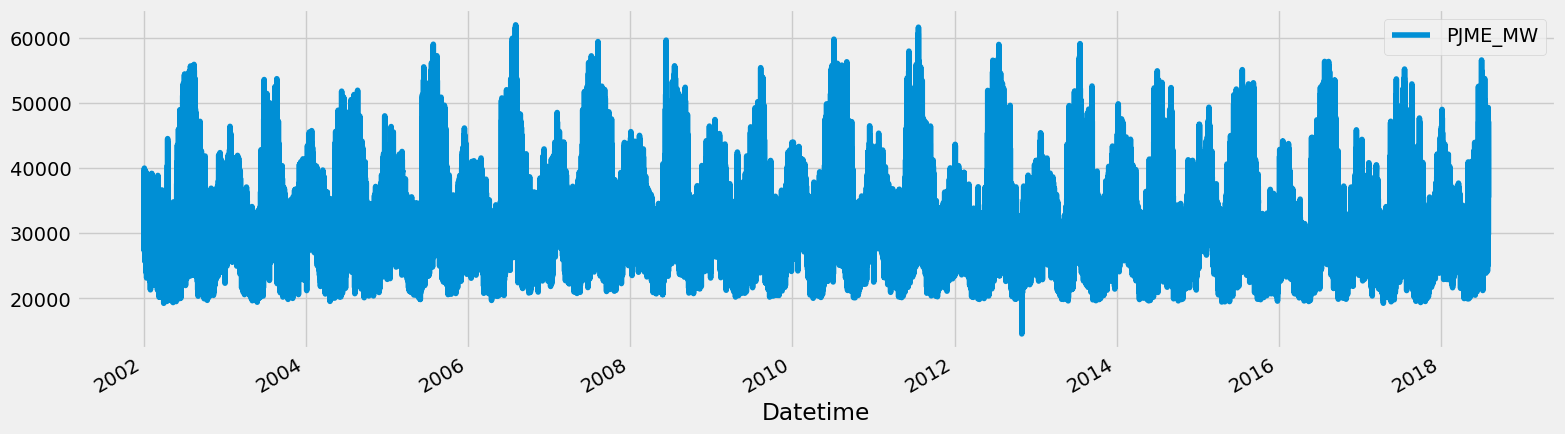

In [5]:
df.plot(color=color_pal[0])
plt.show()

In [6]:
# Outliers

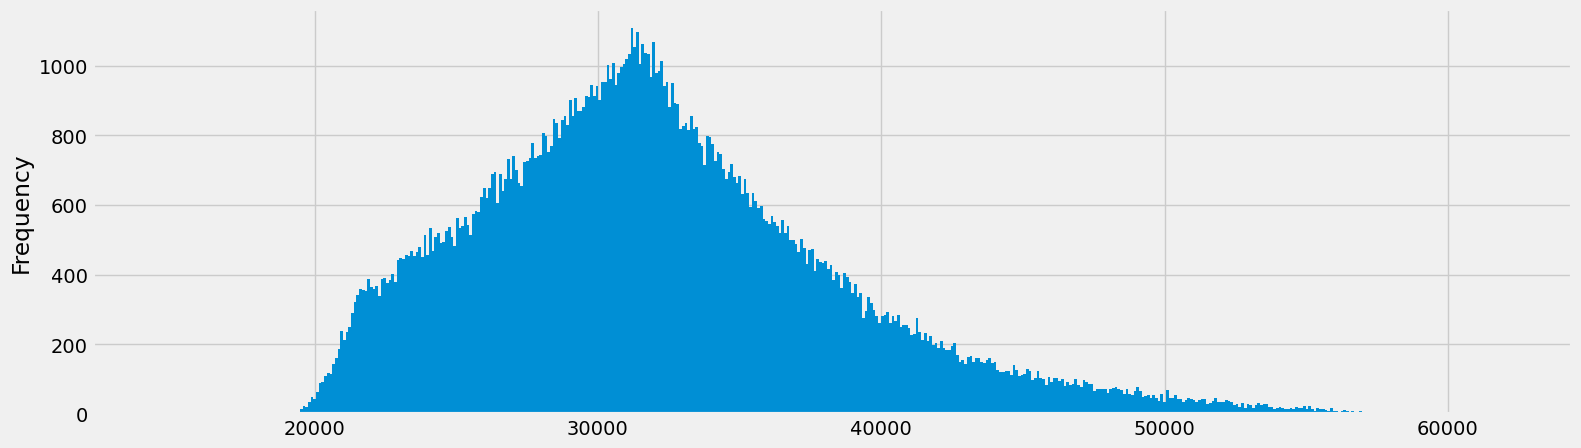

In [7]:
df["PJME_MW"].plot(kind="hist", bins=500)
plt.show()

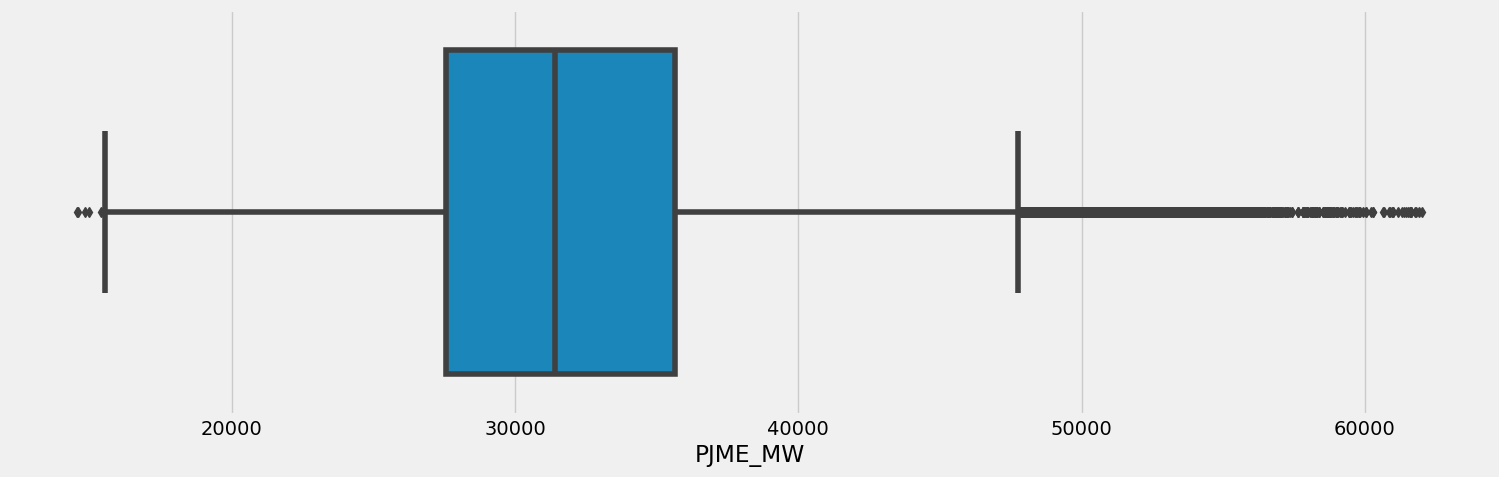

In [8]:
sns.boxplot(df["PJME_MW"])
plt.show()

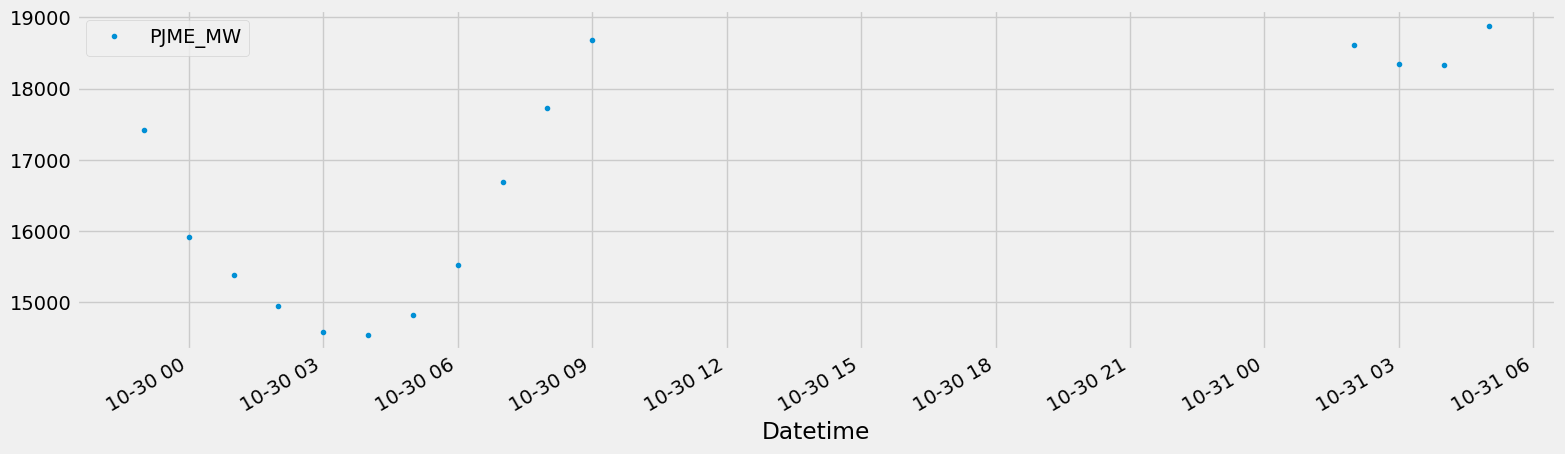

In [9]:
df.query("PJME_MW < 19000").plot(figsize=(17, 5), style=".")
plt.legend(loc=0)

In [10]:
df = df.query("PJME_MW > 19000").copy()

In [11]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [12]:
for train_index, valid_index in tss.split(df):
    break

In [13]:
train_index

array([     0,      1,      2, ..., 101524, 101525, 101526])

In [14]:
valid_index

array([101551, 101552, 101553, ..., 110308, 110309, 110310])

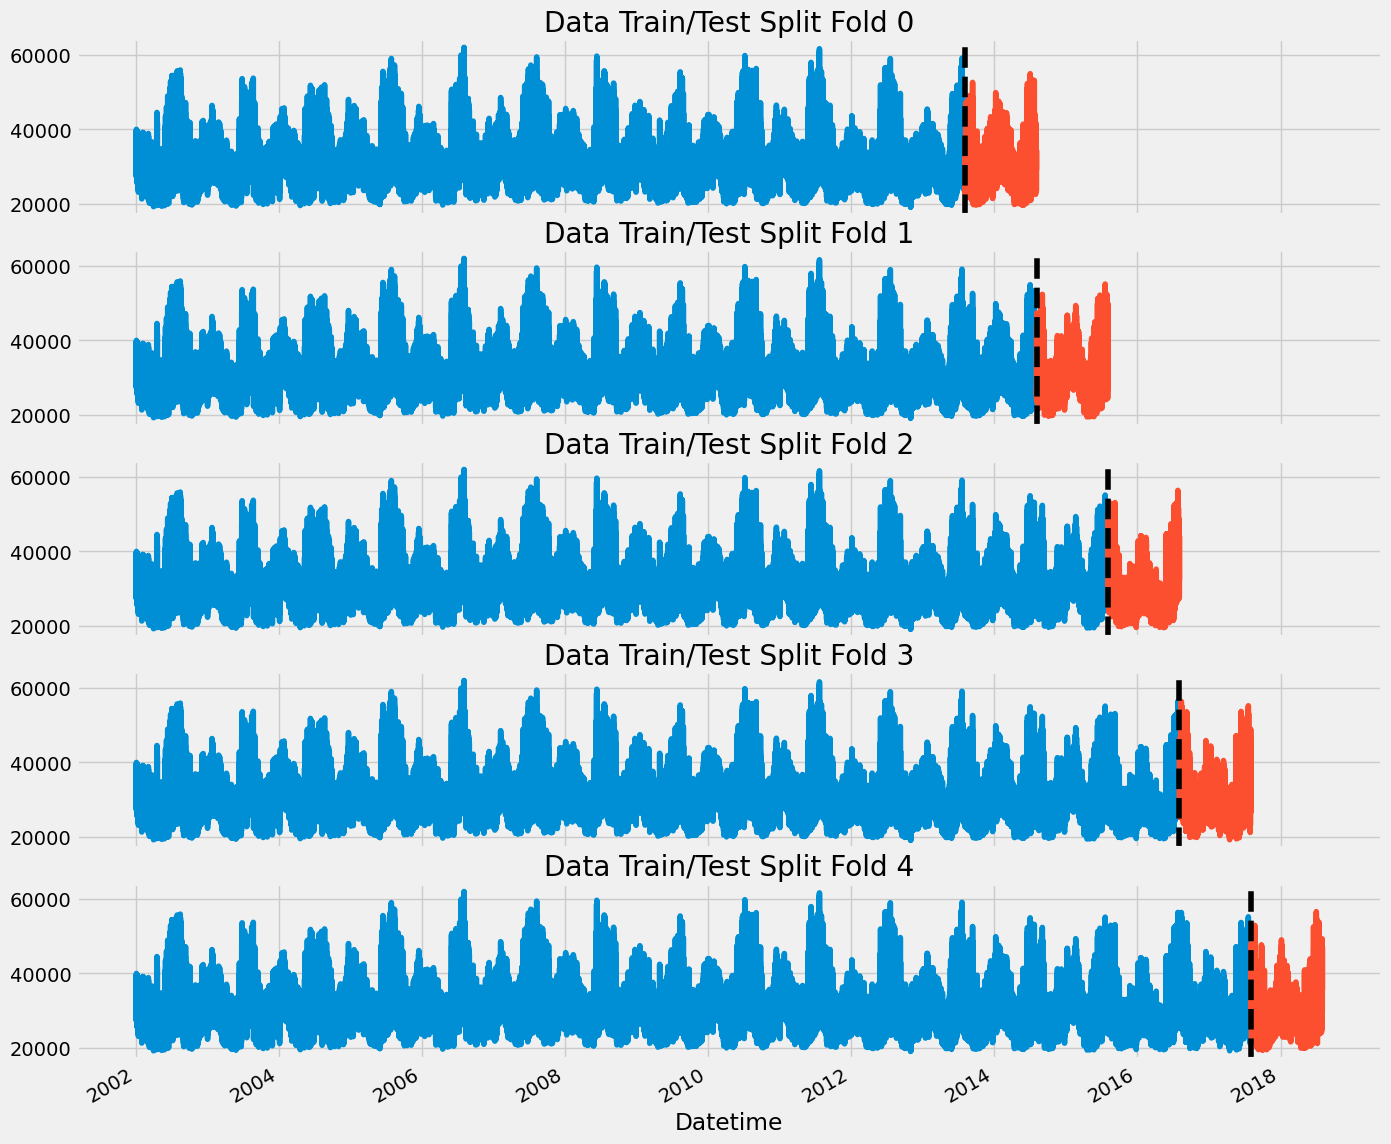

In [15]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15),sharex=True)

fold = 0
for train_index, valid_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[valid_index]
    
    train["PJME_MW"].plot(ax=axs[fold], label="TrainingSet", title=f'Data Train/Test Split Fold {fold}')
    test["PJME_MW"].plot(ax=axs[fold], label="TestSet")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    
    fold += 1

In [16]:
# Forecasting Horizon Explained
# The forecasting horizon is the length of time into the future for which forecasts
#  are to be prepared.
# These generally very from short-term forcasting horizon (three months)
#  to long-term horizons (more than two years).

In [17]:
def create_feature(df):
    
    df = df.copy()
    df["Hour"] = df.index.hour
    df["Day"] = df.index.day
    df["Weekday"] = df.index.weekday
    df["Dayofweek"] = df.index.dayofweek
    df["Month"] = df.index.month
    df["Quarter"] = df.index.quarter
    df["Year"] = df.index.year
    df["Dayofyear"] = df.index.dayofyear
    df["Daysinmonth"] = df.index.daysinmonth
    #df["Leapyear"] = df.index.is_leap_year
    #df["Startofmonth"] = df.index.is_month_start
    #df["Weekofyear"] = df.index.isocalendar().week
    
    return df


In [18]:
# Lag Features

In [19]:
def add_lags(df):
    target_map = df["PJME_MW"].to_dict() ## map these lags into our dataframe
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    
    return df

In [21]:
df = add_lags(df)
df = create_feature(df)

In [22]:
df.tail()

,PJME_MW,lag1,lag2,lag3,Hour,Day,Weekday,Dayofweek,Month,Quarter,Year,Dayofyear,Daysinmonth
Datetime,,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,42256.0,41485.0,38804.0,20,2,3,3,8,3,2018,214,31
2018-08-02 21:00:00,43256.0,41210.0,40249.0,38748.0,21,2,3,3,8,3,2018,214,31
2018-08-02 22:00:00,41552.0,39525.0,38698.0,37330.0,22,2,3,3,8,3,2018,214,31
2018-08-02 23:00:00,38500.0,36490.0,35406.0,34552.0,23,2,3,3,8,3,2018,214,31
2018-08-03 00:00:00,35486.0,33539.0,32094.0,31695.0,0,3,4,4,8,3,2018,215,31


In [23]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_index, valid_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[valid_index]
    
    train = create_feature(train)
    test = create_feature(test)
    
    FEATURES = ['lag1', 'lag2', 'lag3', 'Hour', 'Day', 'Weekday', 'Month', 
                'Quarter', 'Year', 'Dayofyear', 'Daysinmonth']
    TARGET = 'PJME_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                           n_estimators=3000,
                           early_stopping_rounds=50, 
                           objective='reg:squarederror',
                           max_depth=3, 
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
    
    #fold += 1


[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.03479	validation_1-rmse:11905.85141
[200]	validation_0-rmse:5740.22637	validation_1-rmse:5350.26014
[300]	validation_0-rmse:3868.17145	validation_1-rmse:3890.81821
[400]	validation_0-rmse:3429.88474	validation_1-rmse:3755.79602
[448]	validation_0-rmse:3358.09859	validation_1-rmse:3761.56403
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.28282	validation_1-rmse:12222.21946
[200]	validation_0-rmse:5754.98982	validation_1-rmse:5658.66351
[300]	validation_0-rmse:3905.43884	validation_1-rmse:3937.50550
[400]	validation_0-rmse:3475.99854	validation_1-rmse:3601.42994
[500]	validation_0-rmse:3354.21944	validation_1-rmse:3530.51155
[600]	validation_0-rmse:3297.56743	validation_1-rmse:3488.14492
[700]	validation_0-rmse:3255.40479	validation_1-rmse:3466.02043
[800]	validation_0-rmse:3221.17454	validation_1-rmse:3448.00684
[900]	validation_0-rmse:3191.18712	v

In [24]:
scores

[3754.6840181104762,
 3388.5600344329355,
 3475.1567349843212,
 4122.436545213837,
 3998.818045002864]

In [25]:
print(f'Scores across folds {np.mean(scores):0.4f}')
print(f'Fold Scores: {scores}')

Scores across folds 3747.9311
Fold Scores: [3754.6840181104762, 3388.5600344329355, 3475.1567349843212, 4122.436545213837, 3998.818045002864]


In [26]:
# Predicting the Future

In [41]:
df = create_feature(df)

FEATURES = ['lag1', 'lag2', 'lag3', 'Hour', 'Day', 'Weekday', 'Month', 
                'Quarter', 'Year', 'Dayofyear', 'Daysinmonth']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                      booster='gbtree',
                      n_estimators=1000,
                      objective='reg:linear',
                      max_depth=3,
                      learning_rate=0.01)

reg.fit(X_all, y_all,
       eval_set=[(X_all, y_all)],
       verbose=100)

[21:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.42551
[200]	validation_0-rmse:5751.57484
[300]	validation_0-rmse:3971.06193
[400]	validation_0-rmse:3570.24213
[500]	validation_0-rmse:3454.62098
[600]	validation_0-rmse:3400.88406
[700]	validation_0-rmse:3363.63788
[800]	validation_0-rmse:3333.12032
[900]	validation_0-rmse:3307.28553
[999]	validation_0-rmse:3283.76569


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [42]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [43]:
future = pd.date_range('2018-08-03 00:00:00', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True
df['isFuture'] = False

In [44]:
df_and_future = pd.concat([df, future_df])
df_and_future = create_feature(df_and_future)
df_and_future = add_lags(df_and_future)

In [45]:
future_w_features = df_and_future.query('isFuture').copy()

In [46]:
future_w_features

,PJME_MW,lag1,lag2,lag3,Hour,Day,Weekday,Dayofweek,Month,Quarter,Year,Dayofyear,Daysinmonth,isFuture
2018-08-03 00:00:00,NaN,33539.0,32094.0,31695.0,0,3,4,4,8,3,2018,215,31,True
2018-08-03 01:00:00,NaN,30781.0,29503.0,29128.0,1,3,4,4,8,3,2018,215,31,True
2018-08-03 02:00:00,NaN,29015.0,27712.0,27373.0,2,3,4,4,8,3,2018,215,31,True
2018-08-03 03:00:00,NaN,27884.0,26535.0,26233.0,3,3,4,4,8,3,2018,215,31,True
2018-08-03 04:00:00,NaN,27223.0,25870.0,25643.0,4,3,4,4,8,3,2018,215,31,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,46912.0,39352.0,40243.0,20,31,2,2,7,3,2019,212,31,True
2019-07-31 21:00:00,NaN,45985.0,38699.0,39183.0,21,31,2,2,7,3,2019,212,31,True
2019-07-31 22:00:00,NaN,44094.0,37346.0,37759.0,22,31,2,2,7,3,2019,212,31,True
2019-07-31 23:00:00,NaN,40666.0,34555.0,34641.0,23,31,2,2,7,3,2019,212,31,True


In [33]:
# Predict the Future

In [47]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

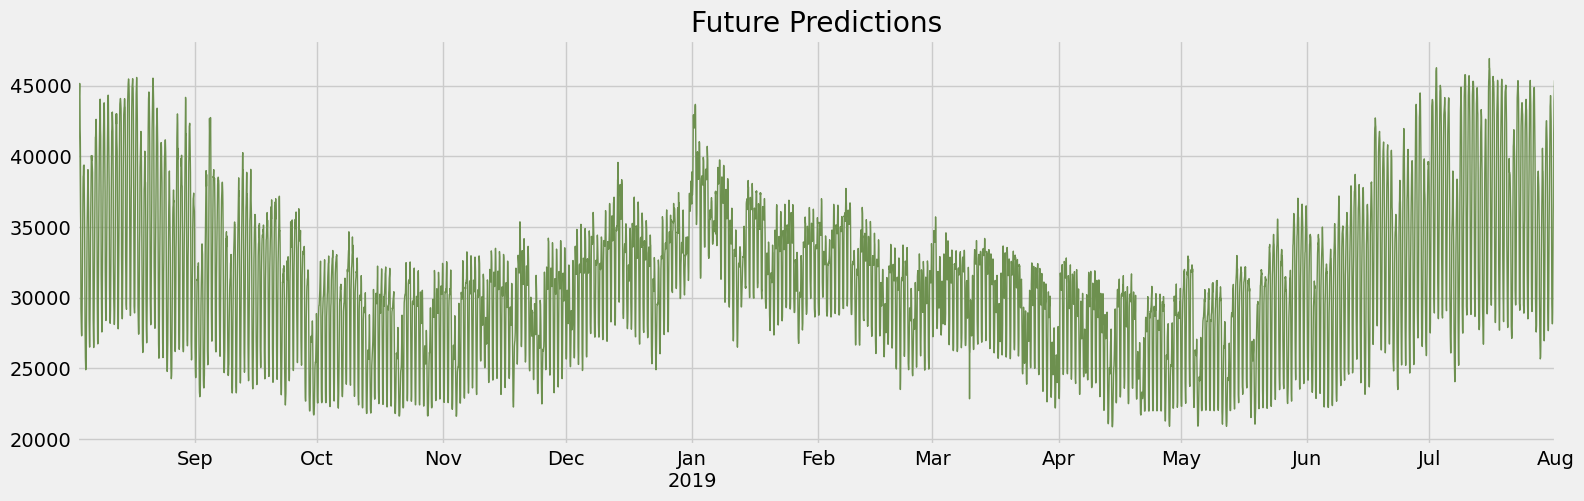

In [48]:
future_w_features['pred'].plot(figsize=(17, 5),
                                color=color_pal[3],
                                ms=1,
                                lw=1,
                                title='Future Predictions')

plt.show()

In [36]:
# Saving Modle

In [49]:
reg.save_model('model.json')

In [38]:
# Load Model

In [50]:
reg_new = xgb.XGBRegressor()
reg_new .load_model('model.json')

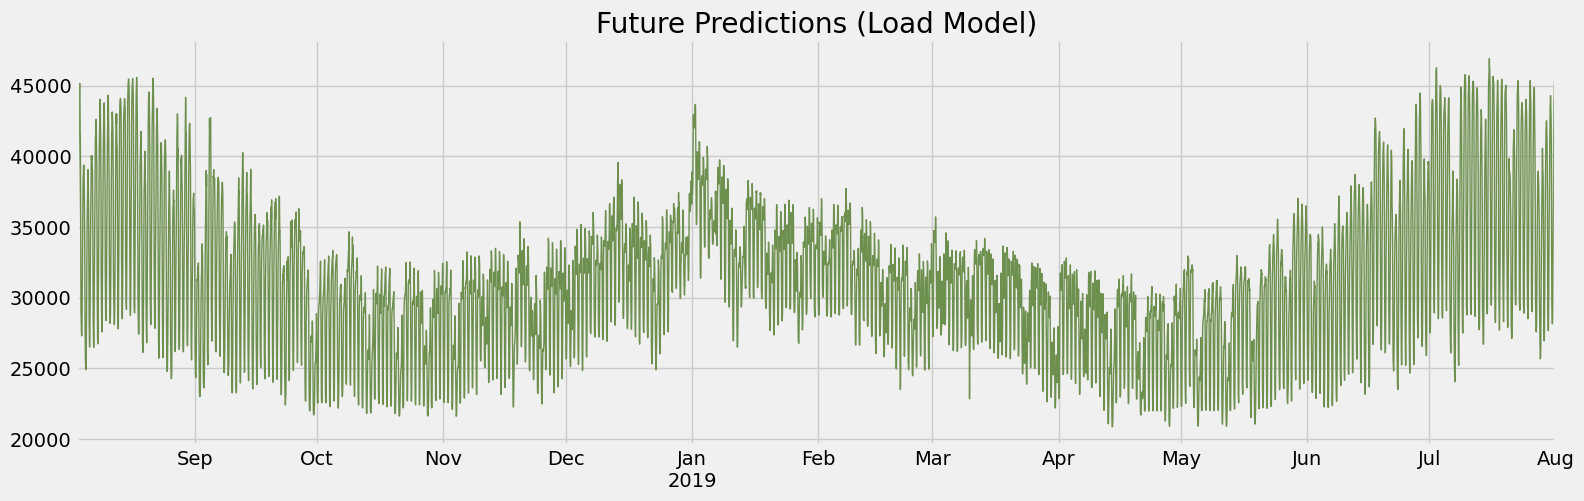

In [51]:
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(17, 5),
                                color=color_pal[3],
                                ms=1,
                                lw=1,
                                title='Future Predictions (Load Model)')
plt.show()